In [1]:
%matplotlib notebook
#%matplotlib inline
import numpy as np
import sympy
import casadi
import modules as M
import matplotlib.pyplot as plt

In [2]:
m = 5
x0 = [0, np.pi/2, 0, 0, 0, 0.8, 0, 0, 0, 0.05]

# get EOM for cyr wheel of mass m and control u.
casadi_EOM, x, u = M.get_casadi_EOM(m)
ode = {}
ode['x'] = x
ode['p'] = u
ode['ode'] = casadi.vertcat(*casadi_EOM)

In [3]:
def opt_JK(total_time, control_steps, guess = 0):
    
    control_time0 = total_time / control_steps
    U = casadi.MX.sym("U", control_steps)
    C = casadi.integrator('C','cvodes', ode, 0, control_time0)
    
    # Construct graph of integrator calls
    
    X = x0
    J = 0
    for k in range(control_steps):
        Ck = C(x0=X, p=U[k])
        X = Ck['xf']
        #J += U[k] ** 2
        if k == 0:
            J += (2 * U[k]) ** 2 / 2
        else:
            J += (U[k] - U[k - 1]) ** 2 
    
    g = [X[4], X[9]]
    target_g = [0, 0]
    
    g.append(X[0] - casadi.arctan(X[7] / X[6]) - np.pi / 2)
    target_g.append(0)
    
    # Allocate an NLP solver
    #nlp = {'x':U, 'f':J}
    nlp = {'x':U, 'f':J, 'g':casadi.vertcat(*g)}
    solver = casadi.nlpsol("solver", "ipopt", nlp)
    
    # Pass bounds, initial guess and solve NLP
    # sol = solver(x0 = CTL_SEQ, lbg = target_g, ubg = target_g)
    sol = solver(x0 = guess, lbg = target_g, ubg = target_g)
    return(sol['x'])

def opt_C2(total_time, control_steps, guess = 0):
    
    control_time0 = total_time / control_steps
    U = casadi.MX.sym("U", control_steps)
    C = casadi.integrator('C','cvodes', ode, 0, control_time0)
    
    # Construct graph of integrator calls
    
    X = x0
    J = 0
    for k in range(control_steps):
        Ck = C(x0=X, p=U[k])
        X = Ck['xf']
        J += U[k] ** 2
        # if k == 0:
        #     J += (2 * U[k]) ** 2 / 2
        # else:
        #     J += (U[k] - U[k - 1]) ** 2 
    
    g = [X[4], X[9]]
    target_g = [0, 0]
    
    g.append(X[0] - casadi.arctan(X[7] / X[6]) - np.pi / 2)
    target_g.append(0)
    
    # Allocate an NLP solver
    #nlp = {'x':U, 'f':J}
    nlp = {'x':U, 'f':J, 'g':casadi.vertcat(*g)}
    solver = casadi.nlpsol("solver", "ipopt", nlp)
    
    # Pass bounds, initial guess and solve NLP
    # sol = solver(x0 = CTL_SEQ, lbg = target_g, ubg = target_g)
    sol = solver(x0 = guess, lbg = target_g, ubg = target_g)
    return(sol['x'])

def validate(CTL_SEQ, total_time, control_steps):

    control_time0 = total_time / control_steps
    tt_sim = np.linspace(0, control_time0, 50)
    
    simulator = casadi.integrator('S','cvodes', ode, 0, tt_sim[1:])
    traj_ss = np.array([x0])
    X = traj_ss[0]
    for i in range(1):
        for k in range(control_steps):
            res = simulator(x0 = X, p = CTL_SEQ[k])
            output = np.array(res["xf"]).T
            traj_ss = np.vstack([traj_ss, output])
            X = output[-1]
        
        for k in range(control_steps):
            res = simulator(x0 = X, p = CTL_SEQ[control_steps - 1 - k])
            output = np.array(res["xf"]).T
            traj_ss = np.vstack([traj_ss, output])
            X = output[-1]
            
        for k in range(control_steps):
            res = simulator(x0 = X, p = - CTL_SEQ[k])
            output = np.array(res["xf"]).T
            traj_ss = np.vstack([traj_ss, output])
            X = output[-1]
            
        for k in range(control_steps):
            res = simulator(x0 = X, p = - CTL_SEQ[control_steps - 1 - k])
            output = np.array(res["xf"]).T
            traj_ss = np.vstack([traj_ss, output])
            X = output[-1]
    
    traj_CT = []
    traj_GC = []
    for i in range(len(traj_ss)):
        traj_CT.append(M.CT(traj_ss[i]))
        traj_GC.append(M.GC(traj_ss[i]))
    traj_CT = np.array(traj_CT)
    traj_GC = np.array(traj_GC)
    
    return traj_CT, traj_GC

def compute_JK(CTL_SEQ):
    CTL_SEQ = np.array(CTL_SEQ).reshape(-1)
    J = 0
    J += (2 * CTL_SEQ[0]) ** 2 / 2
    for i in range(len(CTL_SEQ) - 1):
        J += (CTL_SEQ[i + 1] - CTL_SEQ[i]) ** 2
    return J

In [4]:
Ns = [10, 15, 20]
Ts = np.linspace(3, 8, 15)

JK_SEQ = []
C2_SEQ = []

for i in range(len(Ns)):

    jk_seq = []
    c2_seq = []
    
    for j in range(len(Ts)):
        
        print('THIS IS I = {0} AND J = {1}'.format(i, j))
        c2_seq.append(opt_C2(Ts[j], Ns[i]))
        jk_seq.append(opt_JK(Ts[j], Ns[i]))
        
    JK_SEQ.append(jk_seq)
    C2_SEQ.append(c2_seq)

THIS IS I = 0 AND J = 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       30
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Tota

In [14]:
scores = np.ones((len(Ns), len(Ts)))

for i in range(len(Ns)):
    for j in range(len(Ts)):
        jk_seq = JK_SEQ[i][j]
        c2_seq = C2_SEQ[i][j]
    
        scores[i][j] = compute_JK(jk_seq) / compute_JK(c2_seq)

<IPython.core.display.Javascript object>


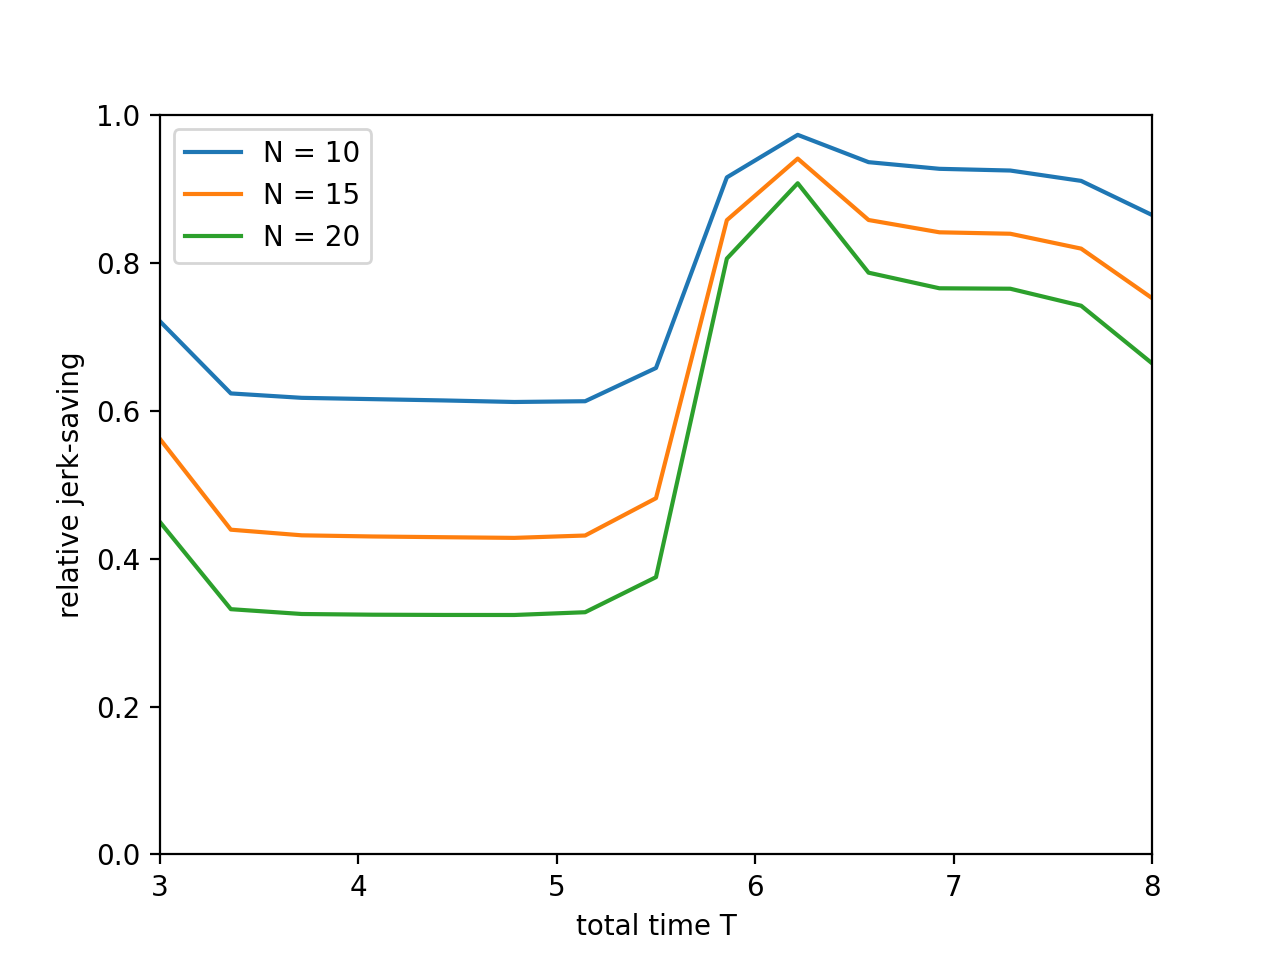

In [20]:
plt.figure()
for i in range(len(Ns)):
    plt.plot(Ts, scores[i, :], label = 'N = {}'.format(Ns[i]))
plt.legend()
plt.ylim(0, 1)
plt.xlim(3, 8)
plt.xlabel('total time T')
plt.ylabel('relative jerk-saving')
plt.savefig('JKSaving - FigOf8.pdf')

<IPython.core.display.Javascript object>


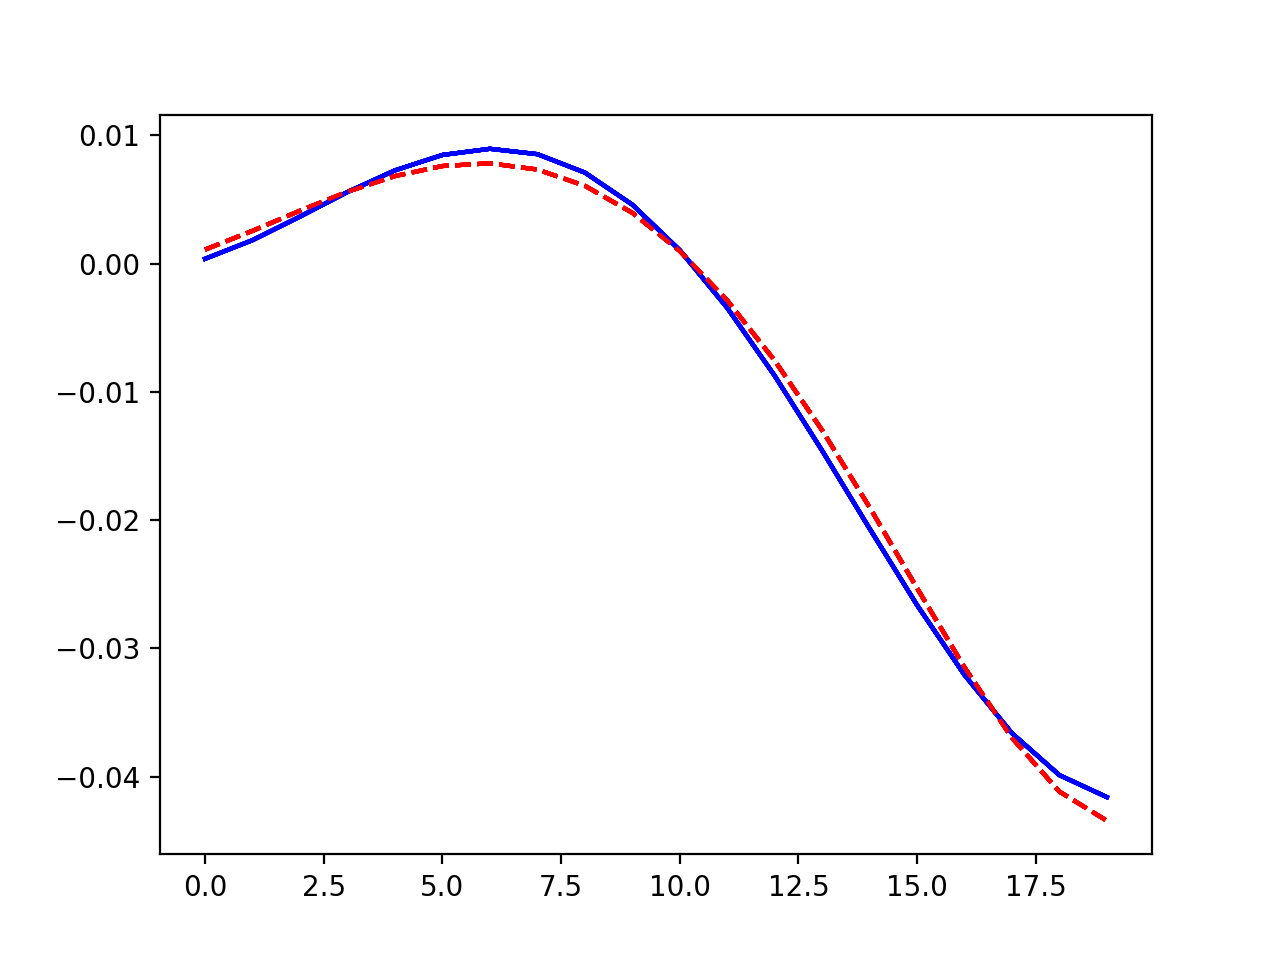

In [6]:
plt.figure()

for i in range(len(JK_SEQ)):
    plt.plot(np.array(JK_SEQ[i]).reshape(-1), color = 'blue')
    plt.plot(np.array(C2_SEQ[i]).reshape(-1), linestyle = 'dashed', color = 'red')

<IPython.core.display.Javascript object>


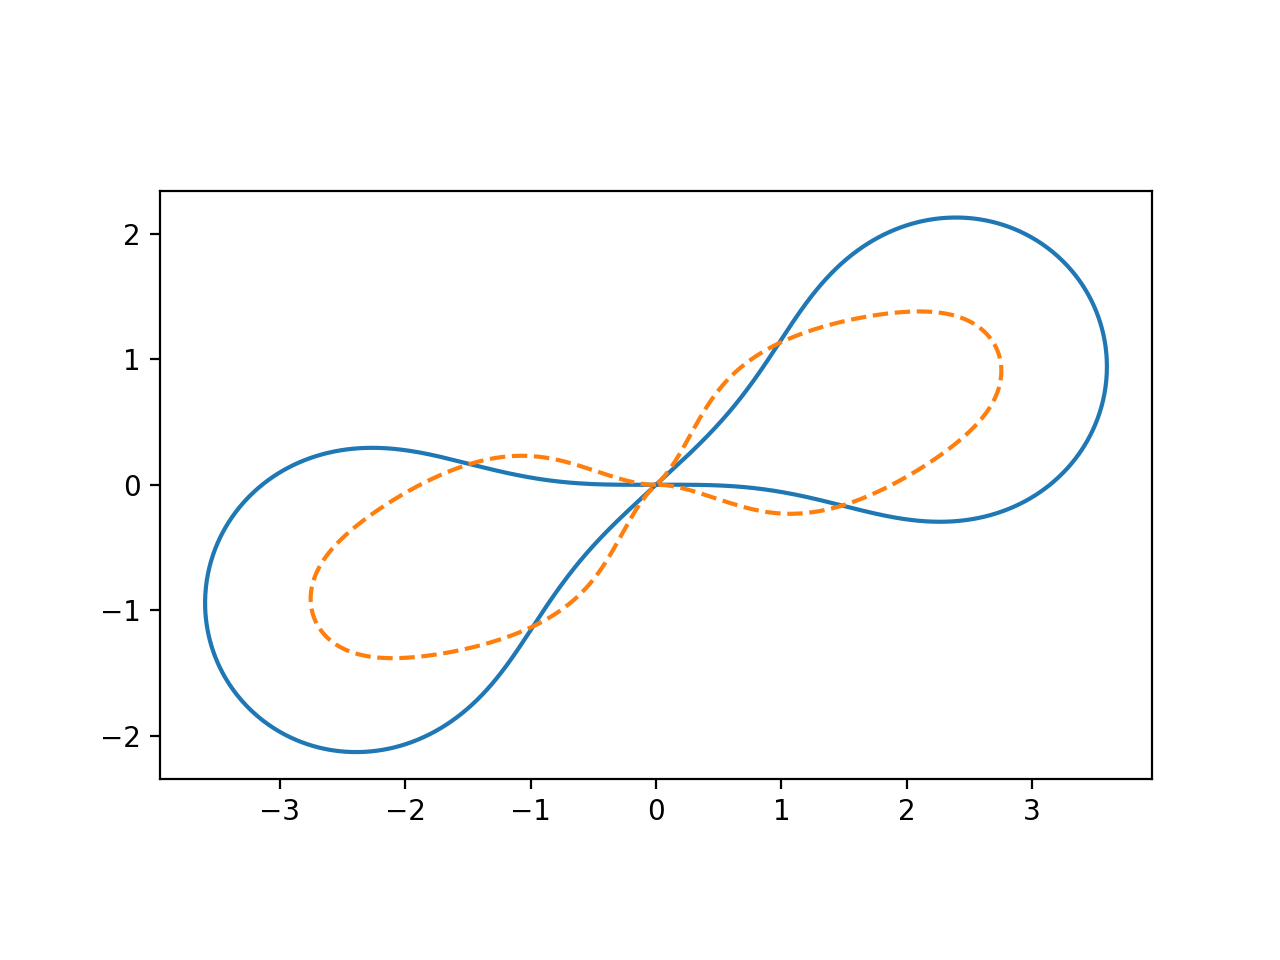

In [29]:
traj_CT, traj_GC = validate(C2_SEQ[2][1], Ts[1], Ns[2])

plt.figure()
plt.axes().set_aspect(1)
plt.plot(traj_CT.T[0], traj_CT.T[1])
plt.plot(traj_GC.T[0], traj_GC.T[1], linestyle = 'dashed')

0.9831729388670631


In [3]:
# total T = 6


control_steps = 20
control_time0 = 0.3
CTL_SEQ = [0.0011004, 0.00256443, 0.00413251, 0.00561564, 0.00683201, 0.00761605, 0.00782524, 0.00734187, 0.00607752, 0.00397179, 0.000992445, -0.00286123, -0.00755131, -0.0129856, -0.0189935, -0.0252951, -0.0314742, -0.0369764, -0.0411618, -0.0434374]
CTL_SEQ_JK = [0.00023228, 0.00180153, 0.00371179, 0.005662, 0.00736383, 0.0085557, 0.0090154, 0.00857088, 0.00710909, 0.00458264, 0.00101432, -0.0035004, -0.00879305, -0.0146245, -0.0206909, -0.0266353, -0.0320667, -0.0365892, -0.0398416, -0.0415445]

In [2]:
# total T = 4.5

m = 5
x0 = [0, np.pi/2, 0, 0, 0, 0.8, 0, 0, 0, 0.05]
control_steps = 15
control_time0 = 0.3
CTL_SEQ = [0.193969, 0.113565, 0.0470725, -0.00530973, -0.0441407, -0.0705652, -0.0859742, -0.091706, -0.0888708, -0.0783249, -0.0608017, -0.0372801, -0.00981094, 0.0169455, 0.0345665]
CTL_SEQ_JK = [0.0545719, 0.14115, 0.140431, 0.0891781, 0.0163462, -0.0566355, -0.115179, -0.150614, -0.159253, -0.141622, -0.101897, -0.0475159, 0.0111965, 0.0617524, 0.0914233]

In [53]:
# total T = 4.5

m = 5
x0 = [0, np.pi/2, 0, 0, 0, 0.8, 0, 0, 0, 0.05]
control_steps = 20
control_time0 = 4.5/20
CTL_SEQ = [0.202889, 0.140674, 0.0860566, 0.0392979, 0.000394205, -0.0309042, -0.0550184, -0.0725104, -0.0839681, -0.0899604, -0.0909745, -0.0874144, -0.0796129, -0.0678652, -0.0525129, -0.0340931, -0.0136097, 0.00704625, 0.024696, 0.0351682]
CTL_SEQ_JK = [0.0399556, 0.123346, 0.149658, 0.135883, 0.0965657, 0.0437943, -0.0127359, -0.0655777, -0.109331, -0.140414, -0.156841, -0.158028, -0.144632, -0.118435, -0.0822533, -0.0398597, 0.00412349, 0.0444223, 0.07554, 0.0925963]

In [37]:
# total T = 3

m = 5
x0 = [0, np.pi/2, 0, 0, 0, 0.8, 0, 0, 0, 0.05]
control_steps = 10
control_time0 = 0.3
CTL_SEQ = [3.05301, -0.167492, -1.13493, -1.26627, -1.12447, -0.904136, -0.659789, -0.312609, 0.457653, 1.89237]
CTL_SEQ_JK = [2.45103, 1.43237, -0.741372, -1.83035, -1.92653, -1.52928, -1.01219, -0.36683, 0.826857, 2.52963]

In [41]:
# total T = 3

m = 5
x0 = [0, np.pi/2, 0, 0, 0, 0.8, 0, 0, 0, 0.05]
control_steps = 20
control_time0 = 0.15
CTL_SEQ = [3.79799, 1.66383, 0.301534, -0.483933, -0.900541, -1.09804, -1.16628, -1.15741, -1.10263, -1.02107, -0.924166, -0.817529, -0.701067, -0.567475, -0.399082, -0.163111, 0.191062, 0.721544, 1.43014, 2.06289]
CTL_SEQ_JK = [1.72797, 3.32331, 2.49254, 0.957098, -0.462195, -1.47682, -2.04583, -2.23154, -2.13618, -1.87152, -1.54062, -1.22344, -0.963969, -0.75876, -0.550253, -0.232212, 0.318863, 1.16768, 2.19366, 2.97889]

In [6]:
target_state = [0, np.pi/2, 0,
                0, 0, -0.5,
                0, 0,
                0, 0]

initial_state = x0

weights = {'theta1' : 1,
           'c1' : 1}

In [73]:
# direct single shooting method

U = casadi.MX.sym("U", control_steps)

# Construct graph of integrator calls
X = initial_state
J = 0
for k in range(control_steps):
    Ck = C(x0=X, p=U[k])
    X = Ck['xf']
    # J += U[k] ** 2
    if k == 0:
        J += (2 * U[k]) ** 2
    else:
        J += (U[k] - U[k - 1]) ** 2 
J /= 20

for i in range(len(STATES)):
    try:
        J += weights[STATES[i]] * (X[i] - target_state[i]) ** 2
    except:
        pass

angle = casadi.arctan(X[7] / X[6])
J += (X[0] - angle - np.pi/2) ** 2

# Allocate an NLP solver
nlp = {'x':U, 'f':J}
solver = casadi.nlpsol("solver", "ipopt", nlp)

# Pass bounds, initial guess and solve NLP
sol = solver(x0  =  0)
#sol = solver(x0  =  CTL_SEQ)
print(sol)
control_sequence = sol['x']

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1799462e+00 0.00e+00 2.64e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [74]:
CTL_SEQ = control_sequence
CTL_SEQ

DM([0.0397357, 0.122746, 0.149028, 0.135444, 0.0964315, 0.0439917, -0.0122455, -0.0648798, -0.108542, -0.139667, -0.156275, -0.157775, -0.144811, -0.11914, -0.0835488, -0.0417679, 0.00162713, 0.0414157, 0.0721544, 0.0890084])

In [7]:
# direct single shooting method

U = casadi.MX.sym("U", control_steps)

# Construct graph of integrator calls

X = initial_state
J = 0
for k in range(control_steps):
    Ck = C(x0=X, p=U[k])
    X = Ck['xf']
    #J += U[k] ** 2
    if k == 0:
        J += (2 * U[k]) ** 2
    else:
        J += (U[k] - U[k - 1]) ** 2 

g = []
target_g = []

for i in range(len(STATES)):
    try:
        _ = weights[STATES[i]]
        g.append(X[i])
        target_g.append(target_state[i])
    except:
        pass
    
g.append(X[0] - casadi.arctan(X[7] / X[6]) - np.pi / 2)
target_g.append(0)

# Allocate an NLP solver
#nlp = {'x':U, 'f':J}
nlp = {'x':U, 'f':J, 'g':casadi.vertcat(*g)}
solver = casadi.nlpsol("solver", "ipopt", nlp)

# Pass bounds, initial guess and solve NLP
# sol = solver(x0 = CTL_SEQ, lbg = target_g, ubg = target_g)
sol = solver(x0 = 0.0, lbg = target_g, ubg = target_g)
print(sol)
control_sequence_2 = sol['x']


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality c

In [76]:
CTL_SEQ = control_sequence_2
CTL_SEQ

DM([0.0399556, 0.123346, 0.149658, 0.135883, 0.0965657, 0.0437943, -0.0127359, -0.0655777, -0.109331, -0.140414, -0.156841, -0.158028, -0.144632, -0.118435, -0.0822533, -0.0398597, 0.00412349, 0.0444223, 0.07554, 0.0925963])

In [77]:
dt = 1e-3
tt_sim = np.arange(0, control_time0 + dt / 2, dt)

simulator = casadi.integrator('S','cvodes', ode, 0, tt_sim[1:])
traj_ss_intermediate = []

X = x0

for k in range(control_steps):
    res = simulator(x0 = X, p = CTL_SEQ[k])
    output = np.array(res["xf"]).T
    traj_ss_intermediate.append(output)
    X = output[-1]

In [78]:
controlled_traj_ss = [x0]
for seg in traj_ss_intermediate:
    for ss in seg:
        controlled_traj_ss.append(ss)
controlled_traj_ss = np.array(controlled_traj_ss)

controlled_traj_CT = []
controlled_traj_GC = []
for i in range(len(controlled_traj_ss)):
    controlled_traj_CT.append(M.CT(controlled_traj_ss[i]))
    controlled_traj_GC.append(M.GC(controlled_traj_ss[i]))
controlled_traj_CT = np.array(controlled_traj_CT)
controlled_traj_GC = np.array(controlled_traj_GC)

<IPython.core.display.Javascript object>


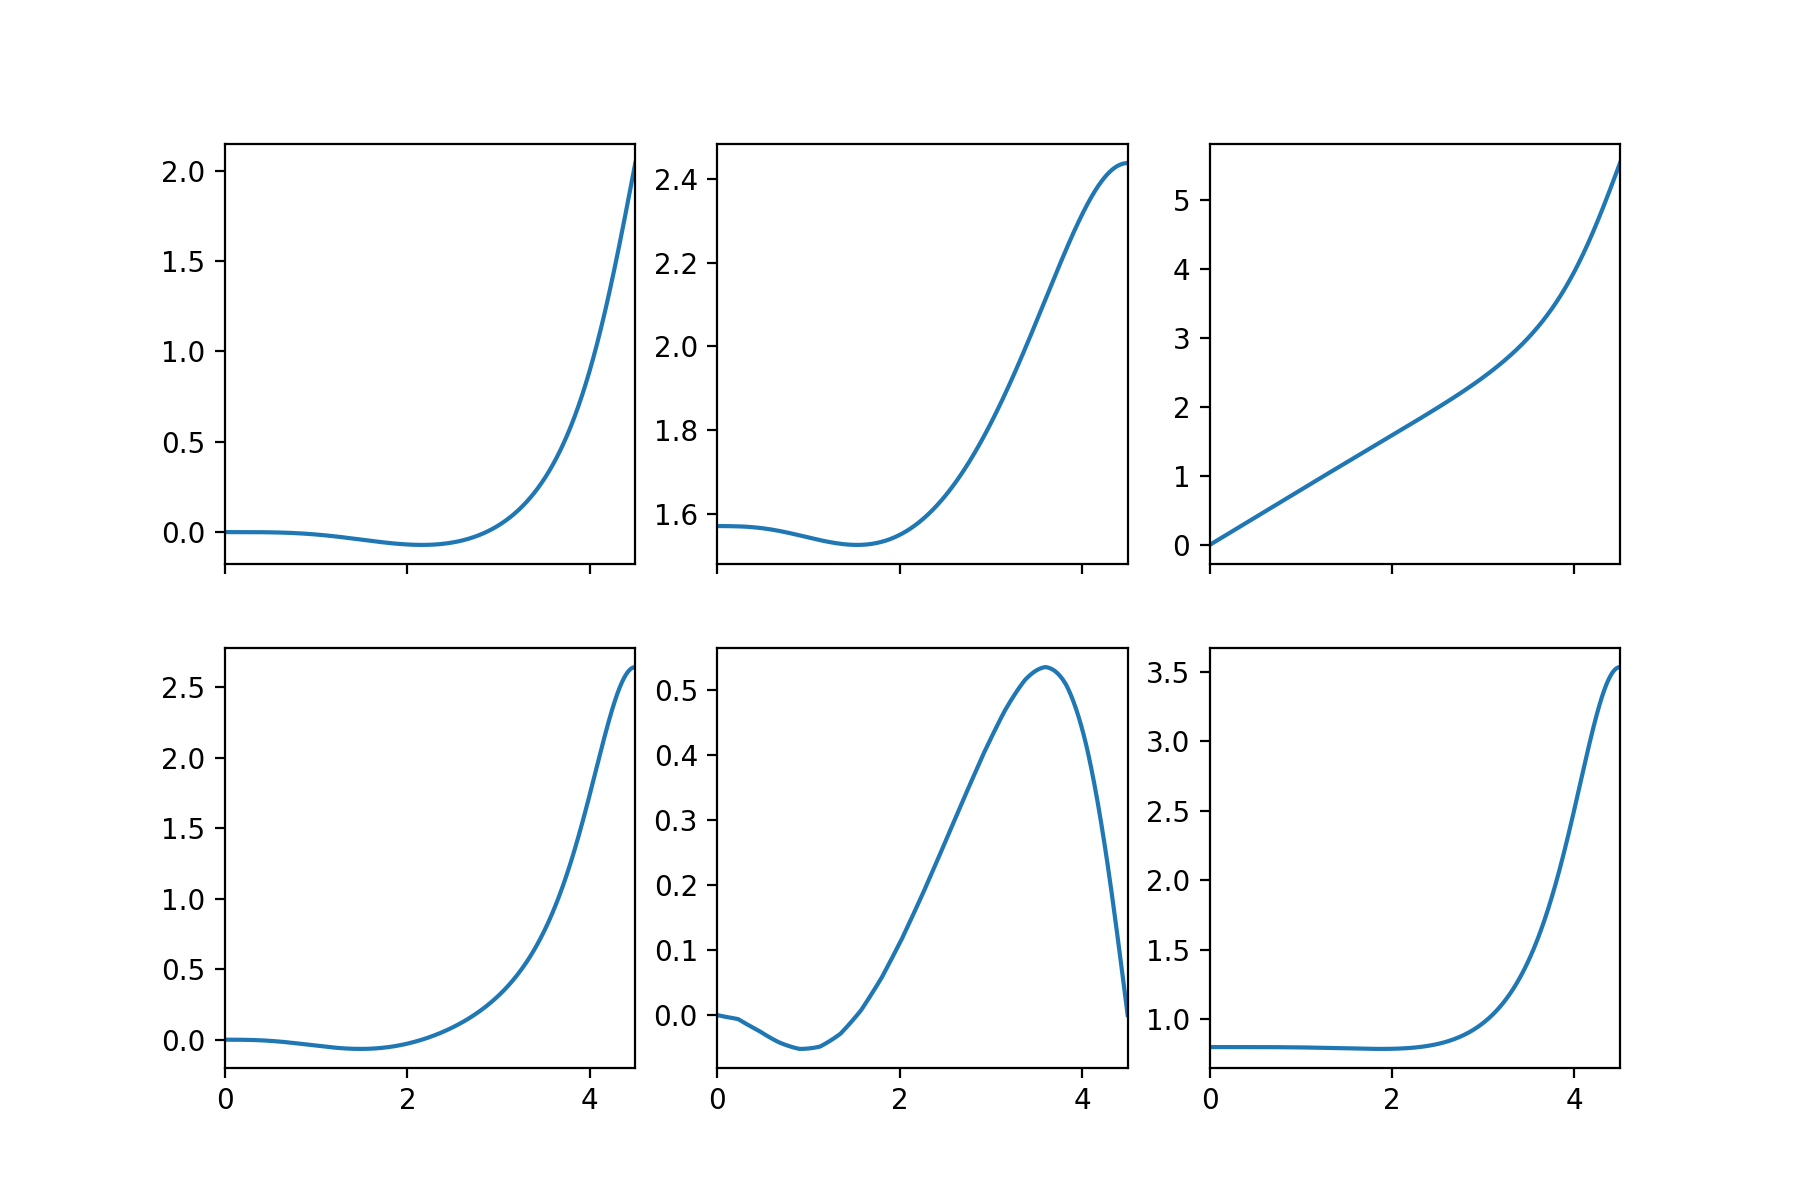

<IPython.core.display.Javascript object>


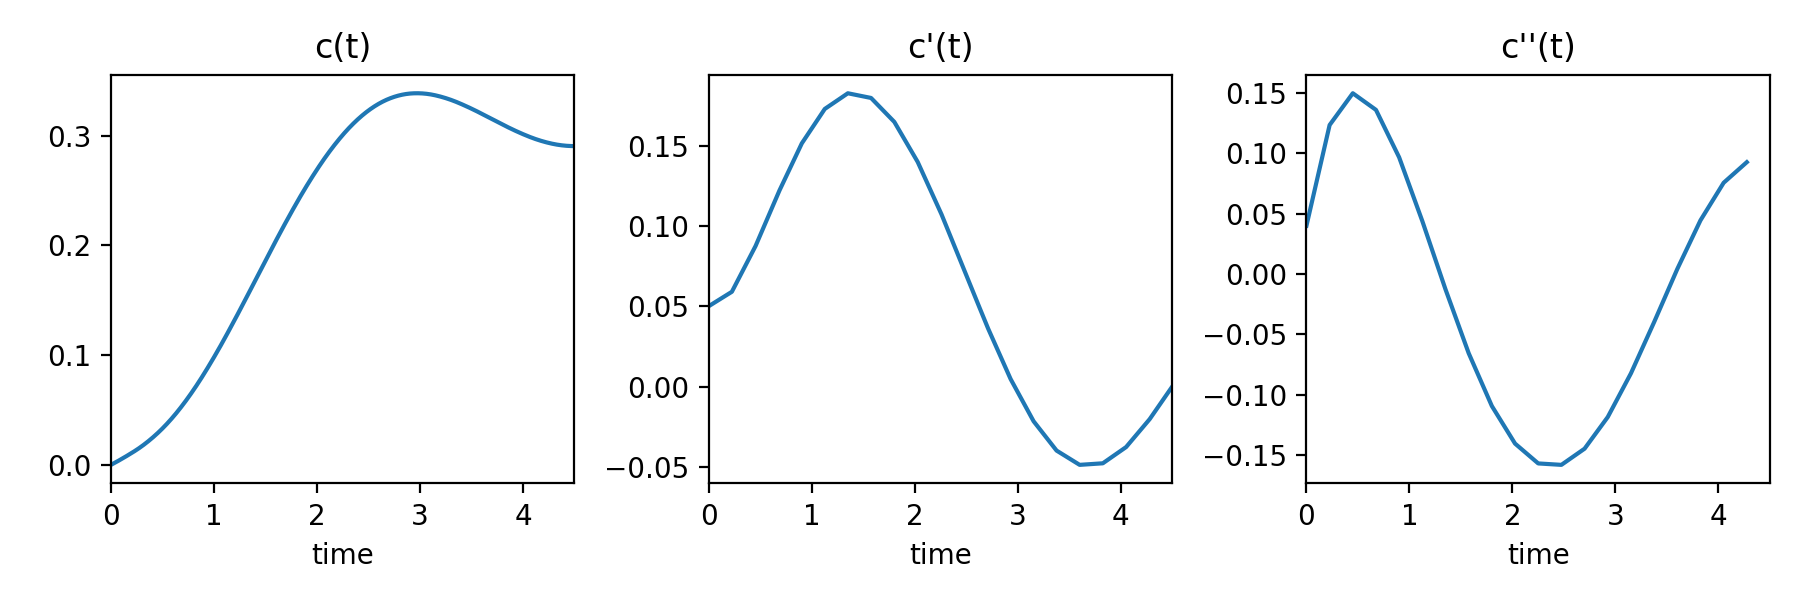

In [79]:
fig, axes = plt.subplots(2, 3, figsize = (9, 6), sharex = True)
axes = np.reshape(axes, -1)
for i in range(6):
    axes[i].plot(np.arange(0,len(controlled_traj_ss))*dt, controlled_traj_ss.T[i])
axes[0].set_xlim(0, control_time0 * control_steps)

fig, axes = plt.subplots(1, 3, figsize = (9, 3), sharex = True)
for i in range(2):
    axes[i].plot(np.arange(0,len(controlled_traj_ss))*dt, controlled_traj_ss.T[8 + i])
axes[2].plot(np.arange(0,control_steps)*control_time0, np.array(CTL_SEQ))
axes[0].set_xlim(0, control_time0 * control_steps)
for i in range(3):
    axes[i].set_xlabel('time')
axes[0].set_title('c(t)')
axes[1].set_title('c\'(t)')
axes[2].set_title('c\'\'(t)')

plt.tight_layout()

#plt.savefig('Fig8_T15_CTL.pdf')

<IPython.core.display.Javascript object>


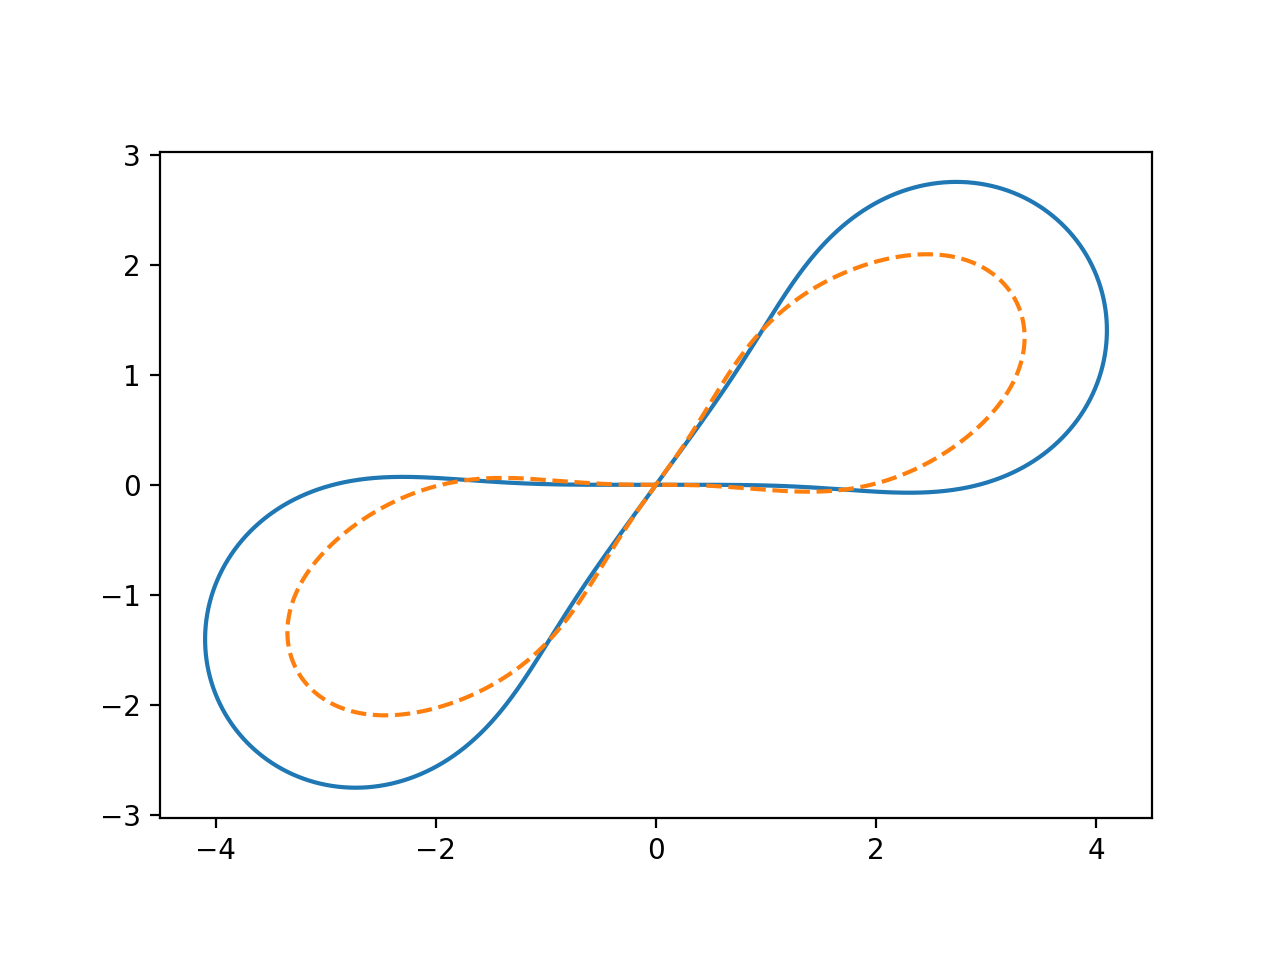

In [80]:
tt_sim = np.arange(0, control_time0 + dt / 2, dt)

simulator = casadi.integrator('S','cvodes', ode, 0, tt_sim[1:])
traj_ss = np.array([x0])
X = traj_ss[0]
for i in range(1):
    for k in range(control_steps):
        res = simulator(x0 = X, p = CTL_SEQ[k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
    
    for k in range(control_steps):
        res = simulator(x0 = X, p = CTL_SEQ[control_steps - 1 - k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
    for k in range(control_steps):
        res = simulator(x0 = X, p = - CTL_SEQ[k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
    for k in range(control_steps):
        res = simulator(x0 = X, p = - CTL_SEQ[control_steps - 1 - k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]

traj_CT = []
traj_GC = []
for i in range(len(traj_ss)):
    traj_CT.append(M.CT(traj_ss[i]))
    traj_GC.append(M.GC(traj_ss[i]))
traj_CT = np.array(traj_CT)
traj_GC = np.array(traj_GC)

plt.figure()
plt.axes().set_aspect(1)
plt.plot(traj_CT.T[0], traj_CT.T[1])
plt.plot(traj_GC.T[0], traj_GC.T[1], linestyle = 'dashed')

<IPython.core.display.Javascript object>


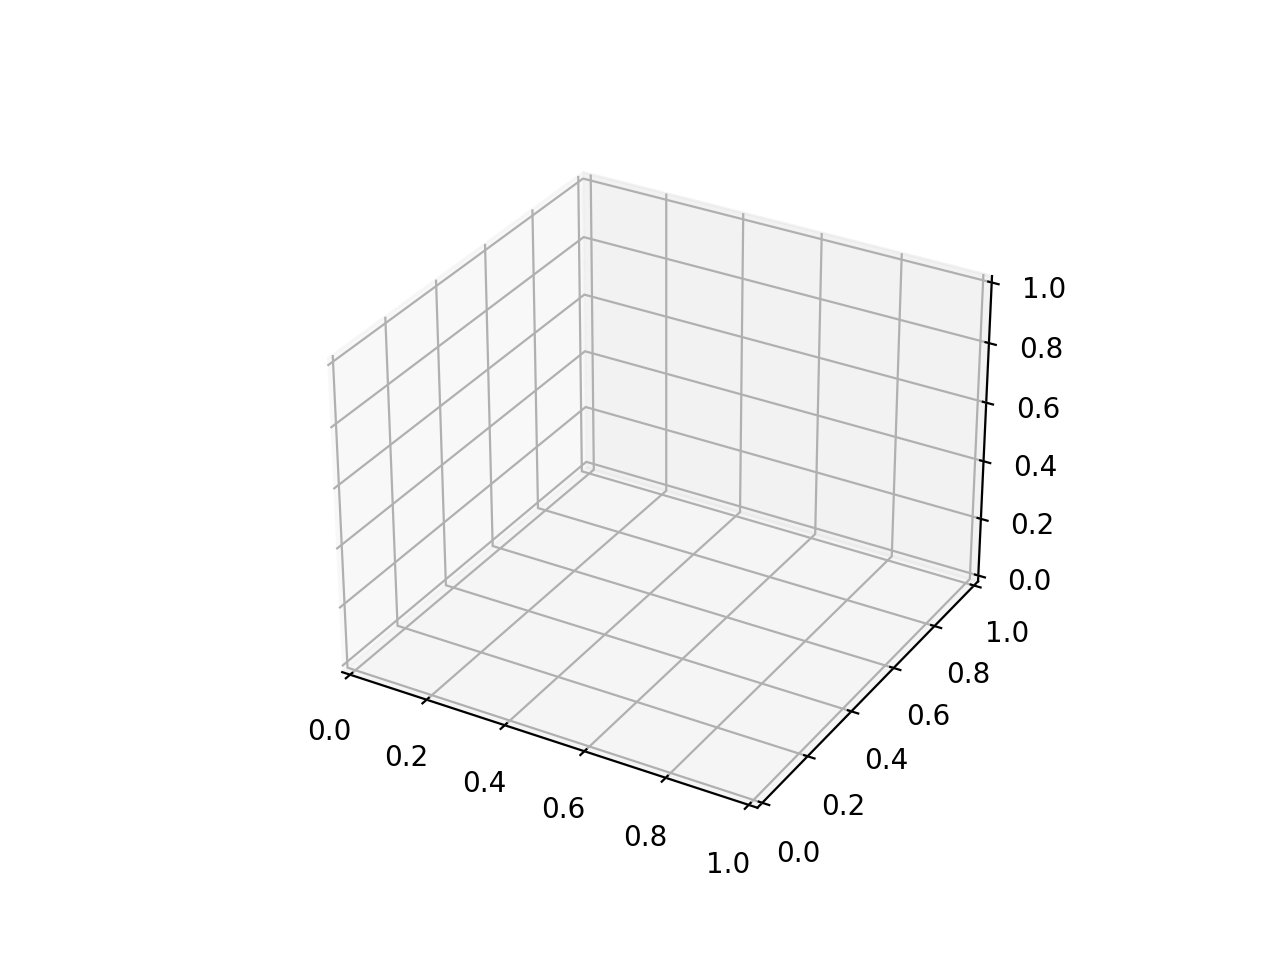

In [51]:
ax = plt.figure().add_subplot(projection='3d')

skip_N = 20

for i in range(len(traj_ss)):
    
    if i % skip_N == 0:
        print("Progress: {0:.1f}%".format(100 * i/len(traj_ss)), end = '\r')
        
        M.DrawCircle(ax, traj_ss[i])
        
        ax.plot(np.array(traj_GC[:i,0]),
                np.array(traj_GC[:i,1]),
                np.array(traj_GC[:i,2]),
                color = 'red', zorder = 1)
        
        ax.plot(np.array(traj_CT[:i,0]),
                np.array(traj_CT[:i,1]),
                np.array(traj_CT[:i,2]),
                color = 'black', zorder = 1)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    
        ax.set_xlim(traj_GC[i,0] - 3, traj_GC[i,0] + 3)
        ax.set_ylim(traj_GC[i,1] - 3, traj_GC[i,1] + 3)
        #ax.set_xlim(- 4, + 4)
        #ax.set_ylim(- 4, + 4)
        ax.set_zlim(0, 6)
    
        plt.savefig('frames/{0:05d}.png'.format(i//skip_N))
        
        ax.clear()

In [26]:
# testing target-searching from either directions

xA = [0, np.pi/2, 0, 0, 0, 0.4, 0, 0, 0, 0.05]

X = xA
for k in range(control_steps):
    res = simulator(x0 = X, p = CTL_SEQ[k])
    output = np.array(res["xf"]).T
    traj_ss = np.vstack([traj_ss, output])
    X = output[-1]

xB = traj_ss[-1]

In [27]:
initial_state = xA
target_state = xB
GUESS_SEQ = CTL_SEQ

In [34]:
# Look for state B starting from state A

U = casadi.MX.sym("U", control_steps)

# Construct graph of integrator calls

X = initial_state
J = 0
for k in range(control_steps):
    Ck = C(x0=X, p=U[k])
    X = Ck['xf']
    J += U[k] ** 2

g = []
target_g = []

# match the state exactly
# for i in range(len(STATES)):
#     g.append(X[i])
#     target_g.append(target_state[i])

# look for approximate match

for i in [4, 9]:
    g.append(X[i])
    target_g.append(target_state[i])

g.append(X[0] - casadi.arctan(X[7] / X[6]) - np.pi / 2)
target_g.append(0)
    
# Allocate an NLP solver
#nlp = {'x':U, 'f':J}
nlp = {'x':U, 'f':J, 'g':casadi.vertcat(*g)}
solver = casadi.nlpsol("solver", "ipopt", nlp)

# Pass bounds, initial guess and solve NLP
sol = solver(x0 = GUESS_SEQ, lbg = target_g, ubg = target_g)
#sol = solver(x0 = 0.0, lbg = target_g, ubg = target_g)
print(sol)

A_to_B_SEQ = sol['x']

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       60
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        3
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.7665923e-02 3.88e-06 5.75e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

<IPython.core.display.Javascript object>


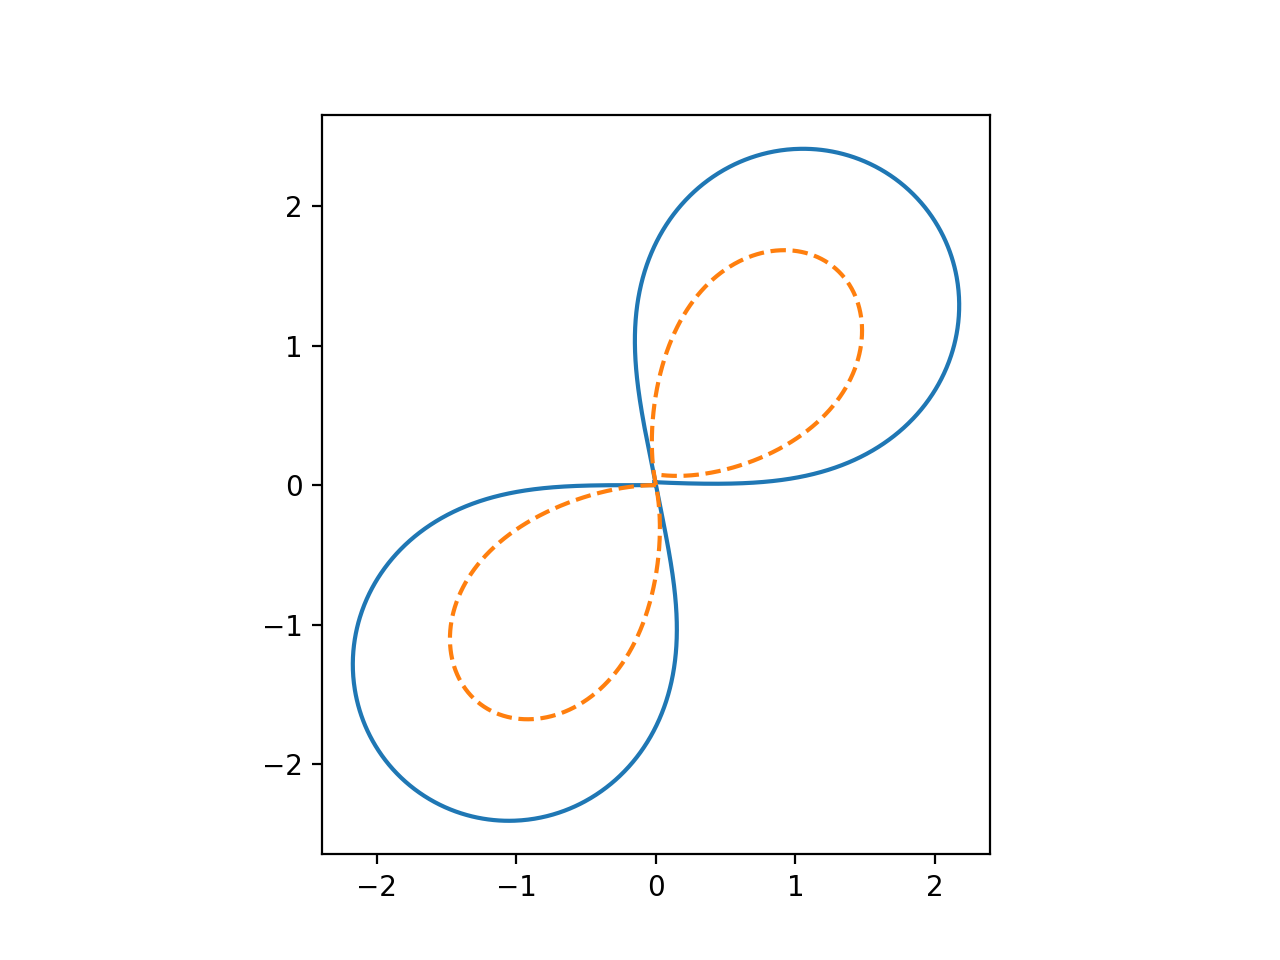

In [35]:
tt_sim = np.arange(0, int(control_time0/dt) * dt + dt, dt)

simulator = casadi.integrator('S','cvodes', ode, 0, tt_sim[1:])
traj_ss = np.array([initial_state])
X = traj_ss[0]

for i in range(1):

    for k in range(control_steps):
        res = simulator(x0 = X, p = A_to_B_SEQ[k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
    
    for k in range(control_steps):
        res = simulator(x0 = X, p = A_to_B_SEQ[control_steps - 1 - k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
    for k in range(control_steps):
        res = simulator(x0 = X, p = - A_to_B_SEQ[k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
    for k in range(control_steps):
        res = simulator(x0 = X, p = - A_to_B_SEQ[control_steps - 1 - k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
    
traj_CT = []
traj_GC = []
for i in range(len(traj_ss)):
    traj_CT.append(M.CT(traj_ss[i]))
    traj_GC.append(M.GC(traj_ss[i]))
traj_CT = np.array(traj_CT)
traj_GC = np.array(traj_GC)

plt.figure()
plt.axes().set_aspect(1)
plt.plot(traj_CT.T[0], traj_CT.T[1])
plt.plot(traj_GC.T[0], traj_GC.T[1], linestyle = 'dashed')

In [15]:
initial_state = xB * np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
target_state = xA * np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
GUESS_SEQ = casadi.vertcat(np.flip(CTL_SEQ).reshape(-1))

In [17]:
# Look for state A starting from state B

U = casadi.MX.sym("U", control_steps)

# Construct graph of integrator calls

X = initial_state
J = 0
for k in range(control_steps):
    Ck = C(x0=X, p=U[k])
    X = Ck['xf']
    J += U[k] ** 2

g = []
target_g = []

# match the state exactly
# for i in range(len(STATES)):
#     g.append(X[i])
#     target_g.append(target_state[i])

# look for approximate match

for i in [1, 3, 4, 8]:
    g.append(X[i])
    target_g.append(target_state[i])
    
# Allocate an NLP solver
#nlp = {'x':U, 'f':J}
nlp = {'x':U, 'f':J, 'g':casadi.vertcat(*g)}
solver = casadi.nlpsol("solver", "ipopt", nlp)

# Pass bounds, initial guess and solve NLP
sol = solver(x0 = GUESS_SEQ, lbg = target_g, ubg = target_g)
#sol = solver(x0 = 0.0, lbg = target_g, ubg = target_g)
print(sol)

B_to_A_SEQ = sol['x']


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       80
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality c

<IPython.core.display.Javascript object>


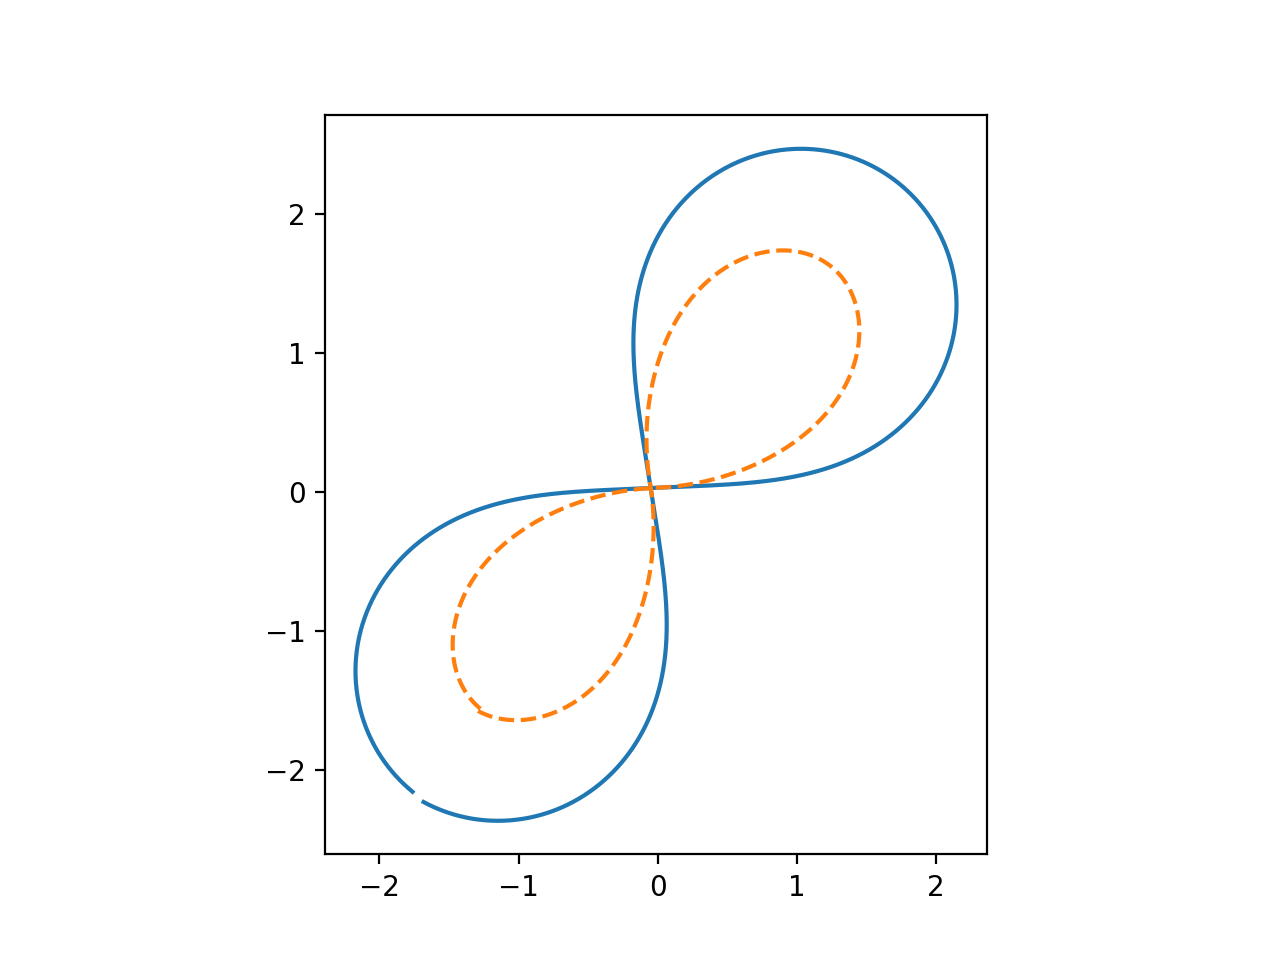

In [18]:
tt_sim = np.arange(0, int(control_time0/dt) * dt + dt, dt)

simulator = casadi.integrator('S','cvodes', ode, 0, tt_sim[1:])
traj_ss = np.array([initial_state])
X = traj_ss[0]

for i in range(1):

    for k in range(control_steps):
        res = simulator(x0 = X, p = B_to_A_SEQ[k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
    
    for k in range(control_steps):
        res = simulator(x0 = X, p = - B_to_A_SEQ[control_steps - 1 - k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
    for k in range(control_steps):
        res = simulator(x0 = X, p = - B_to_A_SEQ[k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
    for k in range(control_steps):
        res = simulator(x0 = X, p = B_to_A_SEQ[control_steps - 1 - k])
        output = np.array(res["xf"]).T
        traj_ss = np.vstack([traj_ss, output])
        X = output[-1]
        
traj_CT = []
traj_GC = []
for i in range(len(traj_ss)):
    traj_CT.append(M.CT(traj_ss[i]))
    traj_GC.append(M.GC(traj_ss[i]))
traj_CT = np.array(traj_CT)
traj_GC = np.array(traj_GC)

plt.figure()
plt.axes().set_aspect(1)
plt.plot(traj_CT.T[0], traj_CT.T[1])
plt.plot(traj_GC.T[0], traj_GC.T[1], linestyle = 'dashed')

In [36]:
xA

[0, 1.5707963267948966, 0, 0, 0, 0.4, 0, 0, 0, 0.05]

In [68]:
4.5/20 / 1e-2

22.5